In [1]:
from comet_ml import Experiment
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

import glob
from tqdm import tqdm
import itertools
from time import time
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import PIL

from IPython import display

In [2]:
BATCH_SIZE = 64
SHUFFLE_BUFFER = 256
experiment = Experiment(api_key=open('../cometml.key').read().strip(), project_name="artgan", workspace="schmidtdominik")
# experiment.log_parameters({'G_learning_rate': model.g_learning_rate, 'D_learning_rate': model.d_learning_rate, 'D_steps': d_steps, 'G_steps': g_steps, 'batch_size': model.batch_size})
# experiment.set_code('\n# [code]: train.py\n' + open('train.py', 'r').read() + '\n# [code]: image_pipeline.py\n' + open('image_pipeline.py', 'r').read() + '\n# [code]: model.py\n' + open('model.py', 'r').read() + '\n# [code]: discriminator.py\n' + open('discriminator.py', 'r').read() + '\n# [code]: generator.py\n' + open('generator.py', 'r').read())

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/schmidtdominik/artgan/c4b2365912574e928c428c38762abb7a



## load dataset

In [3]:
import tensorflow_datasets as tfds

In [4]:
train_dataset = tfds.load(name="celeb_a", split='train', shuffle_files=True)

In [5]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER)
train_dataset = train_dataset.map(lambda x: (tf.cast(x['image'], tf.float32)-127.5)/127.5, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

AxesImage(54,36;334.8x217.44)


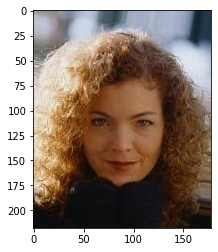

In [6]:
for x in train_dataset:
    print(plt.imshow(x.numpy()[0, :, :]/2+0.5))
    plt.show()
    break

In [7]:
def scale_layer(x, y):
    return tf.keras.layers.Lambda(
        lambda image: tf.image.resize(
            image,
            (x, y),
            method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        )
     )

## generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*6*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 6, 256)))
    assert model.output_shape == (None, 7, 6, 256) # Note: None is the batch size
    
    model.add(scale_layer(14, 12))
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(scale_layer(28, 24))
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(scale_layer(56, 48))
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(scale_layer(112, 96))
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(scale_layer(218, 178))
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh'))
    
    assert model.output_shape == (None, 218, 178, 3)
    return model

## discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[218, 178, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25)) # 112

    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25)) # 56
    
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25)) # 28
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25)) # 14
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25)) # 7

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

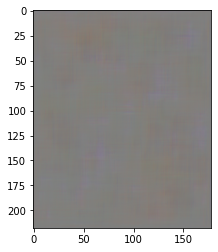

tf.Tensor([[0.00059113]], shape=(1, 1), dtype=float32)


In [10]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :]/2+0.5)
plt.show()

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.99)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.99)

In [15]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## training loop

In [16]:
EPOCHS = 50
noise_dim = 100

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
#current_time = datetime.datetime.now().strftime("%d.%m.%Y-%H:%M:%S")
#log_dir = 'logs/' + current_time
#summary_writer = tf.summary.create_file_writer(log_dir)

In [19]:
def train(dataset):
  steps_per_epoch = 0
  total_steps = 0

  for epoch in itertools.count(0, 1):
    start = time()
    
    for image_batch, step in zip(tqdm(dataset), itertools.count(0, 1)):
      total_steps = epoch*steps_per_epoch + step
      experiment.set_step(total_steps)
        
      G_loss, D_loss = train_step(image_batch)
    
      if step % 5 == 0:
        experiment.log_metrics({'d_loss': G_loss, 'g_loss': D_loss})
        # , 'current_resolution': current_resolution, 'current_mode': (0 if current_mode == 'train' else 1), 'time_to_res_schedule_update': current_resolution_schedule_period_length - (time.time() - last_schedule_update_time)})
        #with summary_writer.as_default():
        #  tf.summary.scalar('G_loss', G_loss, step=total_steps)
        #  tf.summary.scalar('D_loss', D_loss, step=total_steps)
      
      if step % 200 == 0:
        display.clear_output(wait=True)
        show_image(generator, epoch, step)
    
    steps_per_epoch = max(steps_per_epoch, step)
        
    if (epoch + 1) % 1 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Epoch {} time: {}'.format(epoch, time()-start))

**Generate and save images**



In [20]:
def show_image(model, epoch, step):
    n_of_images = 3
    seed = tf.random.normal([n_of_images, noise_dim]) 
    predictions = model(seed, training=False)
    
    fig = plt.figure(figsize=(20, 10))
    for m in range(n_of_images):
        plt.subplot(1, n_of_images, m + 1)
        plt.imshow(predictions[m, :, :]/2+0.5)

    #plt.savefig('./progress_images/epoch_{0}_{1}_{2}x{2}'.format(epoch, current_mode, current_resolution))
    experiment.log_figure(figure_name='epoch={0}_step={1}'.format(epoch, step))
    # _{2}x{2}    ..    current_mode, current_resolution))
    plt.show()
    plt.close()

## training

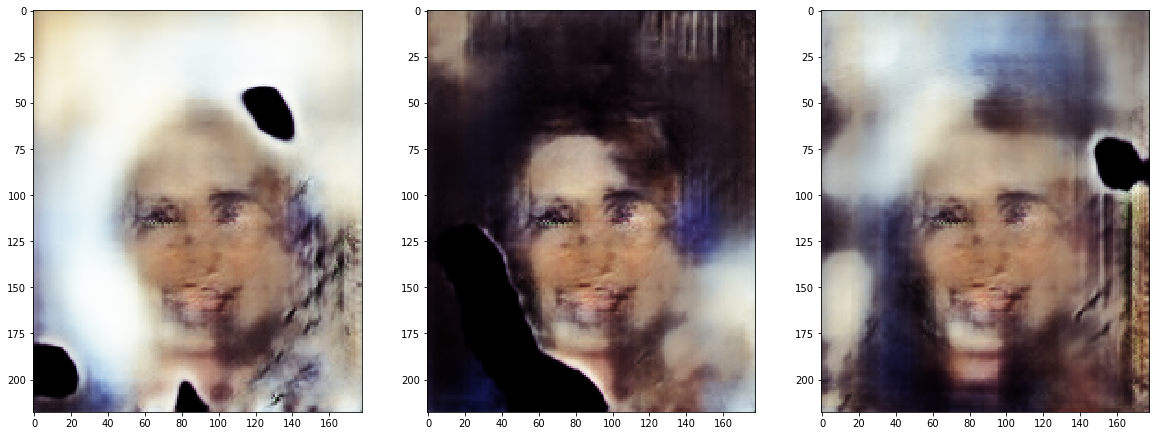

27960it [55:53,  8.78it/s]

KeyboardInterrupt: 

In [21]:
train(train_dataset)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)